In [5]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, CatBoostClassifier
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [6]:
cwd = os.getcwd()
df = pd.read_csv(cwd + r'/data/auto_data_x_v2.csv')
dft = pd.read_csv(cwd + r'/data/test.csv')
dft_f = pd.read_csv(cwd + r'/data/test.csv')
from_file = CatBoostClassifier()
from_file.load_model(cwd + r'/data/model_feature_generator')
sample_submission = pd.read_csv(cwd + r'/data/sample_submission.csv')

In [7]:
def ownerTime_to_month(x):
    y_m = re.findall(r'\d+', x['Владение'])
    if len(y_m) == 0:
        return -1
    elif len(y_m) == 1:
        return int(y_m[0]) * 12
    else:
        return int(y_m[0]) * 12 + int(y_m[1])

<AxesSubplot:>

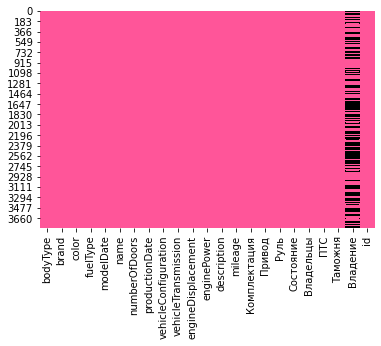

In [8]:
#Проверим тестовый датасет на пропуски:

colours = ['#FF5599', '#000000'] 
sns.heatmap(dft.isnull(), cbar=False, cmap=sns.color_palette(colours))

In [9]:
dft['Владение'].fillna("", inplace=True)
dft['Владение'] = dft.apply(ownerTime_to_month, axis=1)

In [10]:
dft.brand.unique()

array(['BMW'], dtype=object)

Только один бренд "BMW" - удаляем столбец

In [11]:
VERSION    = 11
VAL_SIZE   = 0.25   # 33%
N_FOLDS    = 5
RANDOM_SEED = 42

# CATBOOST
ITERATIONS = 3000
LR         = 0.1

In [12]:
def fill_owners(row):   
    if row['owners'] == np.NaN:
        if row.mileage < 78500:
            owners = 1
        elif row.mileage < 133000:
            owners = 2
        else:
            owners = 3
        return owners
    else:
        return re.findall(r'\d', row['owners'])[0]

In [13]:
def fill_owners_test(row):
    
    if row['Владельцы'] == np.NaN:
        if row.mileage < 78500:
            owners = 1
        elif row.mileage < 133000:
            owners = 2
        else:
            owners = 3
        return owners
    else:
        return re.findall(r'\d', row['Владельцы'])[0]

In [14]:
def preproc_test(df):
    df = df.drop('brand', axis=1)
    df['name'] = df['name'].apply(lambda x: x.split(' ')[0])
    df.drop(['vehicleConfiguration', 'description', 
             'Комплектация',
              'Руль','Состояние', 'Таможня', 'Владение', 'id'], axis=1, inplace=True)
    df['engineDisplacement'] = df.engineDisplacement.apply(
        lambda x: 0 if x.split(' ')[0] == 'undefined' else int(float(x.split(' ')[0])*10))
    df['mileage'] = df.mileage.apply(lambda x: int(x))
    df['modelDate'] = df.modelDate.apply(lambda x: int(x))
    df['numberOfDoors'] = df.numberOfDoors.apply(lambda x: int(x))
    df['Привод'] = df['Привод'].apply(lambda x: x.lower())
    df['Владельцы'] = df.apply(fill_owners_test, axis=1)
    df['enginePower'] = df.enginePower.apply(lambda x: int(x.split(' ')[0]))
    df['productionDate'] = df['productionDate'].apply(lambda x: int(x))
    return df

def preproc_data(df):
    df = df.drop('brand', axis=1)
    df['name'] = df['name'].apply(lambda x: x.split(' ')[0])
    df.drop(['vehicleConfiguration', 'description', 
             'equipment',
             'name_full',
              'wheel','state', 'customs', 'owningTime', 'Unnamed: 0'], axis=1, inplace=True)
    df['engineDisplacement'] = df.engineDisplacement.apply(
        lambda x: 0 if x.split(' ')[0] == 'undefined' else int(float(x.split(' ')[0])*10))
    df['mileage'] = df.mileage.apply(lambda x: int(re.sub(r'[^\d]', '', x)))
    df['drive'] = df.drive.apply(lambda x: x.lower())
    df['enginePower'] = df.enginePower.apply(lambda x: int(x.split(' ')[0]))
    df['owners'] = df.apply(fill_owners, axis=1)
    return df

def preproc_test_feature_generation(df):
    df = df.drop('brand', axis=1)
    df['name'] = df['name'].apply(lambda x: x.split(' ')[0])
    df.drop(['vehicleConfiguration', 'description', 'Комплектация',
              'Руль','Состояние', 'Таможня', 'Владение', 'id', 
             'color', 'mileage', 'ПТС', 'Владельцы'], axis=1, inplace=True)
    df['engineDisplacement'] = df.engineDisplacement.apply(lambda x: x.split(' ')[0])
    df['modelDate'] = df.modelDate.apply(lambda x: int(x))
    df['numberOfDoors'] = df.numberOfDoors .apply(lambda x: int(x))
    df['Привод'] = df['Привод'].apply(lambda x: x.lower())
    df['enginePower'] = df.enginePower.apply(lambda x: int(x.split(' ')[0]))
    df['productionDate'] = df['productionDate'].apply(lambda x: int(x))
    temp = df.columns.to_list()
    temp[-1] = 'drive'
    df.columns=temp
    return df
    
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [15]:
X_sub = preproc_test(dft)
X = preproc_data(df)
X_for_feature = preproc_test_feature_generation(dft_f)
model = from_file.predict(X_for_feature)
X_sub['model'] = model

In [16]:
y = X.loc[:, 'price']
X.drop('price', axis=1, inplace=True)

In [17]:
X_sub.columns = X.columns

In [18]:
X_sub.head()

,bodyType,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,drive,owners,pts,model
0,седан,чёрный,дизель,2016,520d,4,2017,автоматическая,20,190,158836,задний,1,Оригинал,5
1,седан,белый,дизель,2018,318d,4,2019,автоматическая,20,150,10,задний,1,Оригинал,3
2,седан,синий,бензин,2009,550i,4,2012,автоматическая,44,407,120000,полный,2,Оригинал,5
3,внедорожник 5 дв.,белый,дизель,2014,30d,5,2015,автоматическая,30,249,111466,полный,2,Оригинал,x6
4,внедорожник 5 дв.,синий,дизель,2014,M50d,5,2019,автоматическая,30,381,11891,полный,1,Оригинал,x6


feature

In [33]:
regr = RandomForestRegressor(n_estimators=100)
train_forest = X.loc[:, ['productionDate', 'mileage']]
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(train_forest, y, test_size=0.2, random_state=RANDOM_SEED)
regr.fit(X_train_f, y_train_f)
y_pred = regr.predict(X_test_f)
print(f" MAPE: {mape(y_test_f, y_pred ):0.3f}")

 MAPE: 0.339


In [39]:
#Обучим лес на всех данных:
regr.fit(train_forest, y)
X_sub['price_RF'] = (regr.predict(dft.loc[:, ['productionDate', 'mileage']]).round()).astype('int')
X['price_RF'] = (regr.predict(X.loc[:, ['productionDate', 'mileage']]).round()).astype('int')

In [40]:
X.head()

,bodyType,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,drive,owners,pts,model,price_RF
0,хэтчбек 3 дв.,белый,бензин,2007,116i,3,2011,автоматическая,16,115,101000,задний,3,Оригинал,1,649059
1,хэтчбек 5 дв.,красный,бензин,2011,116i,5,2013,автоматическая,16,136,160000,задний,3,Дубликат,1,1168816
2,хэтчбек 5 дв.,серый,дизель,2007,120d,5,2008,автоматическая,20,177,233378,задний,3,Оригинал,1,504402
3,кабриолет,красный,бензин,2007,120i,2,2009,автоматическая,20,156,36000,задний,3,Оригинал,1,1710690
4,хэтчбек 3 дв.,красный,бензин,2007,118i,3,2008,автоматическая,20,136,222400,задний,3,Оригинал,1,505960


In [41]:
# Переводим года изготовления в возраст и возведем возраст в квадрат, добавив новый признак

X['modelDate'] = 2021 - X.modelDate
X_sub['modelDate'] = 2021 - X_sub.modelDate
X_sub['modelDate2'] = X_sub['modelDate'] ** 2
X['modelDate2'] = X['modelDate'] ** 2

X['productionDate'] = 2021 - X.productionDate
X_sub['productionDate'] = 2021 - X_sub.productionDate
X_sub['productionDate2'] = X['productionDate'] ** 2
X['productionDate2'] = X['productionDate'] ** 2

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [43]:
cat_features = ['bodyType', 'color', 'fuelType', 'name', 'vehicleTransmission', 'engineDisplacement', 
                'drive', 'pts', 'owners', 'model']

## Запуск CatBoost

In [44]:
model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
model.fit(X_train, y_train,
            cat_features=cat_features,
            eval_set=(X_test, y_test),
            verbose_eval=1000,
            use_best_model=True,
            plot=False)


0:	learn: 1.4770392	test: 1.4664641	best: 1.4664641 (0)	total: 56.9ms	remaining: 2m 50s
1000:	learn: 0.0769232	test: 0.1035948	best: 0.1035912 (974)	total: 3.89s	remaining: 7.77s
2000:	learn: 0.0644815	test: 0.1028488	best: 0.1026034 (1861)	total: 7.74s	remaining: 3.86s
2999:	learn: 0.0558917	test: 0.1040099	best: 0.1026034 (1861)	total: 11.6s	remaining: 0us

bestTest = 0.1026033895
bestIteration = 1861

Shrink model to first 1862 iterations.


In [45]:
model.fit(X, y,
        cat_features=cat_features,
            verbose_eval=1000,
            use_best_model=True,
            plot=False)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 1.4617861	total: 5.86ms	remaining: 17.6s
1000:	learn: 0.0800085	total: 4.49s	remaining: 8.96s
2000:	learn: 0.0688748	total: 8.41s	remaining: 4.2s
2999:	learn: 0.0616330	total: 12.4s	remaining: 0us


In [46]:
predict_submission = model.predict(X_sub)
predict_submission

array([1518931.32643031, 2775871.54645455, 1322118.05007156, ...,
        478567.0847668 , 1381053.57054324, 1263972.91092098])

In [49]:
sample_submission = pd.read_csv(cwd + '/data/sample_submission.csv')
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1846520
1,1,10478924
2,2,1141126
3,3,1586438
4,4,2817210
5,5,1369370
6,6,1206912
7,7,821575
8,8,1278306
9,9,2088448
